In [1]:
%load_ext lab_black
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class PID:
    def __init__(self, K_p, K_i, K_d):
        self.K_p, self.K_i, self.K_d = K_p, K_i, K_d
        self.setpoint = None
        self.output = 0
        self.initialized = False
        self._last_t, self._last_input = None, None
        self.p, self.i, self.d = 0, 0, 0

    def __repr__(self):
        return f"<{self.__class__.__name__}: K_p={self.K_p}, K_i={self.K_i}, K_d={self.K_d}>"

    def update(self, t, input_):
        """Recalculate output with given input_ at given time t."""
        if not self.initialized:
            self._last_t = t
            self._last_input = input_
            self.setpoint = input_
            self.initialized = True
            return 0

        Δt = t - self._last_t
        error = self.setpoint - input_
        Δinput = input_ - self._last_input
        self._last_t = t
        self._last_input = input_

        self.p = self.K_p * error
        self.i += self.K_i * Δt * error
        self.d = -self.K_d * Δinput / Δt
        return self.p + self.i + self.d

# Setup

In [3]:
pid = PID(K_p=0.04, K_i=0.005, K_d=1e-3)

print(pid)

<PID: K_p=0.04, K_i=0.005, K_d=0.001>


# Simulate

In [4]:
def ramp(t, start=30, end=60, T0=22, T1=100):
    if t <= start:
        return T0
    elif start < t < end:
        return T0 + (T1 - T0) * (t - start) / (end - start)
    else:
        return T1


ramp = np.vectorize(ramp)


t = np.arange(0, 100, 0.1)
output = []
p, i, d = [], [], []
value = [22]
for t_ in t:
    pid.setpoint = ramp(t_)
    value.append(value[-1])
    o = pid.update(t_, value[-1])
    value[-1] += o
    value[-1] -= 0.01 * (
        value[-1] - 22
    )  # cooling proportional to ΔT to room temperature
    value[-1] += 0.2 * (2 * np.random.random() - 1)  # some measurement noise
    output.append(o)
    p.append(pid.p)
    i.append(pid.i)
    d.append(pid.d)

# Plot

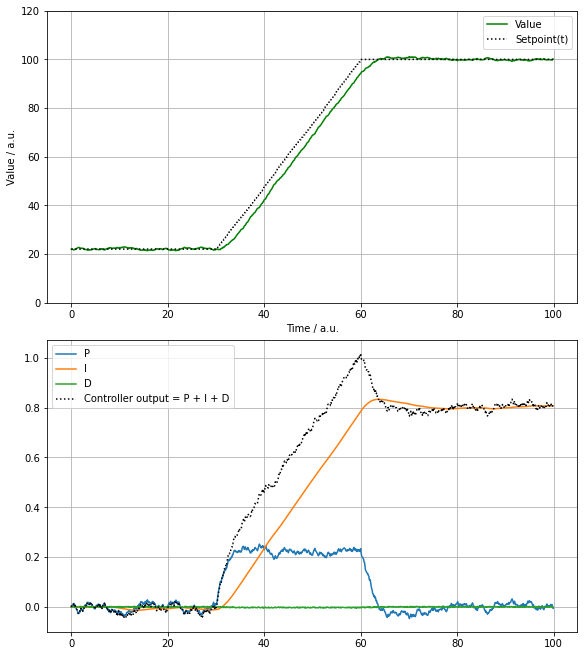

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(8, 9), constrained_layout=True)

ax[1].plot(t, p, label="P")
ax[1].plot(t, i, label="I")
ax[1].plot(t, d, label="D")
ax[1].plot(t, output, label="Controller output = P + I + D", ls=":", c="k")
ax[0].plot(t, value[:-1], label="Value", c="g")
ax[0].plot(t, ramp(t), ls=":", c="k", label="Setpoint(t)")
ax[0].set_xlabel("Time / a.u.")
ax[0].set_ylabel("Value / a.u.")
ax[0].set_ylim(0, 120)
ax[0].grid()
ax[1].grid()

ax[0].legend()
ax[1].legend()
plt.show()